Necessary packages:

- `conda install -c anaconda scipy` 
- `conda install -c conda-forge gdal`
- `pip install opencv-python`

To use it better with jupyter notebook:
- `python -m ipykernel install --user --name aye --display-name="aye"`

In [2]:
import numpy as np
import matplotlib.mlab as ml
import scipy.interpolate as il #for method2, in case the matplotlib griddata method fails
from osgeo import gdal
from osgeo import osr
import pandas as pd

import cv2

import matplotlib.pylab as plt
from mpl_toolkits import mplot3d

import pickle

from datetime import datetime

import pathlib as pl

In [3]:
%matplotlib notebook

In [4]:
data_folder = pl.Path('../../to-review/AYE/sample')

# Utility functions

In [5]:
# Constants.
a = (0.0080, -0.1692, 25.3851, 14.0941, -7.0261, 2.7081)
b = (0.0005, -0.0056, -0.0066, -0.0375, 0.0636, -0.0144)
c = (0.6766097, 2.00564e-2, 1.104259e-4, -6.9698e-7, 1.0031e-9)
d = (3.426e-2, 4.464e-4, 4.215e-1, -3.107e-3)
e = (2.070e-5, -6.370e-10, 3.989e-15)
P = (4.577801212923119e-3, 1.924049429136640e-1, 2.183871685127932e-5,
     -7.292156330457999e-3, 1.568129536470258e-4, -1.478995271680869e-6,
     9.086442524716395e-4, -1.949560839540487e-5, -3.223058111118377e-6,
     1.175871639741131e-7, -7.522895856600089e-5, -2.254458513439107e-6,
     6.179992190192848e-7, 1.005054226996868e-8, -1.923745566122602e-9,
     2.259550611212616e-6, 1.631749165091437e-7, -5.931857989915256e-9,
     -4.693392029005252e-9, 2.571854839274148e-10, 4.198786822861038e-12)
q = (5.540896868127855e-5, 2.015419291097848e-1, -1.445310045430192e-5,
     -1.567047628411722e-2, 2.464756294660119e-4, -2.575458304732166e-7,
     5.071449842454419e-3, -9.081985795339206e-5, -3.635420818812898e-6,
     2.249490528450555e-8, -1.143810377431888e-3, 2.066112484281530e-5,
     7.482907137737503e-7, 4.019321577844724e-8, -5.755568141370501e-10,
     1.120748754429459e-4, -2.420274029674485e-6, -4.774829347564670e-8,
     -4.279037686797859e-9, -2.045829202713288e-10, 5.025109163112005e-12)
r = (3.432285006604888e-3, 1.672940491817403e-1, 2.640304401023995e-5,
     1.082267090441036e-1, -6.296778883666940e-5, -4.542775152303671e-7,
     -1.859711038699727e-1, 7.659006320303959e-4, -4.794661268817618e-7,
     8.093368602891911e-9, 1.001140606840692e-1, -1.038712945546608e-3,
     -6.227915160991074e-6, 2.798564479737090e-8, -1.343623657549961e-10,
     1.024345179842964e-2, 4.981135430579384e-4, 4.466087528793912e-6,
     1.960872795577774e-8, -2.723159418888634e-10, 1.122200786423241e-12)
u = (5.180529787390576e-3, 1.052097167201052e-3, 3.666193708310848e-5,
     7.112223828976632, -3.631366777096209e-4, -7.336295318742821e-7,
     -1.576886793288888e+2, -1.840239113483083e-3, 8.624279120240952e-6,
     1.233529799729501e-8, 1.826482800939545e+3, 1.633903983457674e-1,
     -9.201096427222349e-5, -9.187900959754842e-8, -1.442010369809705e-10,
     -8.542357182595853e+3, -1.408635241899082, 1.660164829963661e-4,
     6.797409608973845e-7, 3.345074990451475e-10, 8.285687652694768e-13)
k = 0.0162

a, b, c, d, e, P, q, r, u, k = (np.asarray(x)
                                for x in (a, b, c, d, e, P, q, r, u, k))

In [6]:
def depthToPressure(depth, density=1.025, g=9.80665):
    # pressure in kPa
    return depth*density*g

def kPaToDecibars(pressure):
    return pressure/10.
    
def soundVelocity(S, T, P0):
    """SOUND SPEED SEAWATER CHEN AND MILLERO 1977, JASA, 62, 1129-1135
     ----------------------------------------------------------
     UNITS:
       PRESSURE     P0    DECIBARS
       TEMPERATURE  T     DEG CELSIUS (IPTS-68)
       SALINITY     S     (PSS-78)
       SOUND SPEED  SVEL  METERS/SECOND
     ----------------------------------------------------------
     CHECKVALUE:
       SVEL=1731.995 M/S for S=40 (PSS-78), T=40 DEG C, P=10000 DBAR
     ----------------------------------------------------------
     Original fortran code is found in:
       UNESCO technical papers in marine science 44 (1983) -
       'Algorithms for computation of fundamental properties of seawater'
     ----------------------------------------------------------
     Translated to object pascal by:
       Dr. Jan Schulz, 21. May 2008, www.code10.info
       
     Translated to python by:
       Dr. Andrea Munafo, 40. Apr 2020, andrea.munafo@gmail.com
    """
    # SCALE PRESSURE TO BARS
    P  = P0 / 10;
    SR = np.sqrt(np.abs(S))

    # S**2 TERM
    D = 1.727e-3 - 7.9836e-6 * P

    # S**3/2 TERM
    B1 =  7.3637E-5 + 1.7945E-7 * T
    B0 = -1.922E-2  - 4.42E-5   * T
    B  = B0 + B1 * P

    # S**1 TERM
    A3 = (-3.389E-13    * T + 6.649E-12)  * T + 1.100E-10
    A2 = ((7.988E-12    * T - 1.6002E-10) * T + 9.1041E-9) * T - 3.9064E-7
    A1 = (((-2.0122E-10 * T + 1.0507E-8)  * T - 6.4885E-8) * T - 1.2580E-5) * T + 9.4742E-5
    A0 = (((-3.21E-8    * T + 2.006E-6)   * T + 7.164E-5)  * T - 1.262E-2)  * T + 1.389
    A  = ((A3 * P + A2) * P + A1) * P + A0

    # S**0 TERM
    C3 = (-2.3643E-12   * T + 3.8504E-10) * T - 9.7729E-9
    C2 = (((1.0405E-12  * T - 2.5335E-10) * T + 2.5974E-8) * T - 1.7107E-6)  * T + 3.1260E-5
    C1 = (((-6.1185E-10 * T + 1.3621E-7)  * T - 8.1788E-6) * T + 6.8982E-4)  * T + 0.153563
    C0 = ((((3.1464E-9  * T - 1.47800E-6) * T + 3.3420E-4) * T - 5.80852E-2) * T + 5.03711) * T + 1402.388
    C  = ((C3 * P + C2) * P + C1) * P + C0;

    # SOUND SPEED RETURN
    SVEL = C + (A + B * SR + D * S) * S

    return SVEL
 
    
    
    
    
def conductivityToSalinity(C, t, p):
    """
    Calculates Practical Salinity, SP, from conductivity, C, primarily
    using the PSS-78 algorithm.  Note that the PSS-78 algorithm for Practical
    Salinity is only valid in the range 2 < SP < 42.  If the PSS-78 algorithm
    produces a Practical Salinity that is less than 2 then the Practical
    Salinity is recalculated with a modified form of the Hill et al. (1986)
    formula. The modification of the Hill et al. (1986) expression is to ensure
    that it is exactly consistent with PSS-78 at SP = 2.  Note that the input
    values of conductivity need to be in units of mS/cm (not S/m).
    Parameters
    
    From https://github.com/TEOS-10/python-gsw/blob/master/gsw/gibbs/practical_salinity.py
    ----------
    C : array
        conductivity [mS cm :sup:`-1`]
    t : array
        in-situ temperature [:math:`^\circ` C (ITS-90)]
    p : array
        sea pressure [dbar]
        (i.e. absolute pressure - 10.1325 dbar)
    Returns
    -------
    SP : array
         Practical Salinity [psu (PSS-78), unitless]
    Examples
    --------
    TODO
    References
    ----------
    .. [1] Culkin and Smith, 1980:  Determination of the Concentration of
       Potassium Chloride Solution Having the Same Electrical Conductivity, at
       15C and Infinite Frequency, as Standard Seawater of Salinity 35.0000
       (Chlorinity 19.37394), IEEE J. Oceanic Eng, 5, 22-23.
    .. [2] Hill, K.D., T.M. Dauphinee & D.J. Woods, 1986: The extension of the
       Practical Salinity Scale 1978 to low salinities. IEEE J. Oceanic Eng.,
       11, 109 - 112.
    .. [3] IOC, SCOR and IAPSO, 2010: The international thermodynamic equation
       of seawater - 2010: Calculation and use of thermodynamic properties.
       Intergovernmental Oceanographic Commission, Manuals and Guides No. 56,
       UNESCO (English), 196 pp.  Appendix E.
    .. [4] Unesco, 1983: Algorithms for computation of fundamental properties
       of seawater.  Unesco Technical Papers in Marine Science, 44, 53 pp.
    """

    C, t, p = np.broadcast_arrays(C, t, p, subok=True)

    t68 = t * 1.00024
    ft68 = (t68 - 15) / (1 + k * (t68 - 15))

    # The dimensionless conductivity ratio, R, is the conductivity input, C,
    # divided by the present estimate of C(SP=35, t_68=15, p=0) which is
    # 42.9140 mS/cm (=4.29140 S/m), (Culkin and Smith, 1980).

    R = 0.023302418791070513 * C  # 0.023302418791070513 = 1./42.9140

    # rt_lc corresponds to rt as defined in the UNESCO 44 (1983) routines.
    rt_lc = c[0] + (c[1] + (c[2] + (c[3] + c[4] * t68) * t68) * t68) * t68
    Rp = (1 + (p * (e[0] + e[1] * p + e[2] * p ** 2)) /
         (1 + d[0] * t68 + d[1] * t68 ** 2 + (d[2] + d[3] * t68) * R))
    Rt = R / (Rp * rt_lc)

    #Rt[Rt < 0] = np.ma.masked
    Rtx = np.sqrt(Rt)

    SP = (a[0] + (a[1] + (a[2] + (a[3] + (a[4] + a[5] * Rtx) * Rtx) * Rtx) *
                  Rtx) * Rtx + ft68 *
          (b[0] + (b[1] + (b[2] + (b[3] + (b[4] + b[5] * Rtx) * Rtx) * Rtx) *
                   Rtx) * Rtx))

    # The following section of the code is designed for SP < 2 based on the
    # Hill et al. (1986) algorithm.  This algorithm is adjusted so that it is
    # exactly equal to the PSS-78 algorithm at SP = 2.

    I2, = np.nonzero(np.ravel(SP) < 2)
    if len(I2) > 0:
        Hill_ratio = Hill_ratio_at_SP2(t[I2])
        x = 400 * Rt[I2]
        sqrty = 10 * Rtx[I2]
        part1 = 1 + x * (1.5 + x)
        part2 = 1 + sqrty * (1 + sqrty * (1 + sqrty))
        SP_Hill_raw = SP[I2] - a[0] / part1 - b[0] * ft68[I2] / part2
        SP[I2] = Hill_ratio * SP_Hill_raw

    SP = np.maximum(SP, 0)  # Ensure that SP is non-negative.

    return SP

In [45]:
def eTimeToEpoch(eTime):
    eTime = [eTime] if not isinstance(eTime, list) else eTime
    epoch = []
    for et in eTime:
        utc_time = datetime.strptime(et, "%d-%b-%Y %H:%M:%S")
        epoch_time = (utc_time - datetime(1970, 1, 1)).total_seconds()
        epoch.append(epoch_time)
    return epoch

def epochToString(epoch):
    epoch = [epoch] if not isinstance(epoch, list) else epoch
    strings = []
    for e in epoch:
        strings.append(e.fromtimestamp(epoch).strftime('%c'))
    return strings

# Reading the CTD

In [7]:
salinity = conductivityToSalinity(C=18.0502, t=0.000185, p=kPaToDecibars(depthToPressure(1.539)))
sv = soundVelocity(S=salinity, T=0.000185, P0=kPaToDecibars(depthToPressure(1.539))) 

sv

1430.222523942128

In [12]:
ctd_file = data_folder/'M086_CTD.csv'

In [13]:
ctd_df = pd.read_csv(ctd_file, sep=';')

In [14]:
ctd_df.head()

,eTime,eTimeStart,T1,T2,C1,C2,Depth,DO,LSS,EH,rho1,rho2
0,10-Aug-2015 16:30:02,10-Aug-2015 16:30:01,0.000185,0.000011,18.0502,16.4716,1.539,0.0,-1.7590,998.6018,998.8794,0.0
1,10-Aug-2015 16:30:03,10-Aug-2015 16:30:01,0.000186,0.000014,18.0459,16.4531,1.524,0.0,-1.7591,998.6025,998.8830,0.0
2,10-Aug-2015 16:30:04,10-Aug-2015 16:30:01,0.000199,0.000010,18.0423,16.4627,1.501,0.0,-1.7593,998.6031,998.8810,0.0
3,10-Aug-2015 16:30:05,10-Aug-2015 16:30:01,0.000201,0.000012,18.0402,16.4716,1.492,0.0,-1.7593,998.6035,998.8800,0.0
4,10-Aug-2015 16:30:06,10-Aug-2015 16:30:01,0.000196,0.000010,18.0386,16.4745,1.487,0.0,-1.7594,998.6037,998.8792,0.0


## Calculating Sound Speed Profiles from CTD measurements


| Variable Name | Meaning |
|---------------|---------------
|T1 °C    | CTD Temperature 1 |
|T2 °C    | CTD Temperature 2 |
|C1       | CTD Conductivity&1 |
|C2       | CTD Conductivity&2 |
|Depth m  | CTD depth |
|DO V     | CTD – Dissolved oxygen reading |
|LSS V    | CTD – Light scattering sensor reading |
|EH V     | CTD – EH Sensor reading |
|rho1 Kg/m3  | CTD – Calculated density1 using the seabird program |
|rho2 Kg/m3  | CTD – Calculated density2 using the seabird program |



In [60]:
ssp = []
for index, row in ctd_df.iterrows():
    salinity = conductivityToSalinity(C=row['C1'], t=row['T1'], p=kPaToDecibars(depthToPressure(row['Depth']))) 
    sv = soundVelocity(S=salinity, T=row['T1'], P0=kPaToDecibars(depthToPressure(row['Depth']))) 
    ssp.append(sv)

Add the ssp to the pandas dataframe

In [61]:
ctd_df['ssp'] = ssp 

In [62]:
ctd_df.head()

,eTime,eTimeStart,T1,T2,C1,C2,Depth,DO,LSS,EH,rho1,rho2,epoch,ssp
0,10-Aug-2015 16:30:02,10-Aug-2015 16:30:01,0.000185,0.000011,18.0502,16.4716,1.539,0.0,-1.7590,998.6018,998.8794,0.0,1.439224e+09,1430.222524
1,10-Aug-2015 16:30:03,10-Aug-2015 16:30:01,0.000186,0.000014,18.0459,16.4531,1.524,0.0,-1.7591,998.6025,998.8830,0.0,1.439224e+09,1430.215132
2,10-Aug-2015 16:30:04,10-Aug-2015 16:30:01,0.000199,0.000010,18.0423,16.4627,1.501,0.0,-1.7593,998.6031,998.8810,0.0,1.439224e+09,1430.208829
3,10-Aug-2015 16:30:05,10-Aug-2015 16:30:01,0.000201,0.000012,18.0402,16.4716,1.492,0.0,-1.7593,998.6035,998.8800,0.0,1.439224e+09,1430.205198
4,10-Aug-2015 16:30:06,10-Aug-2015 16:30:01,0.000196,0.000010,18.0386,16.4745,1.487,0.0,-1.7594,998.6037,998.8792,0.0,1.439224e+09,1430.202436


## Adding epoch

In [39]:
epoch_time = eTimeToEpoch(ctd_df['eTime'].values)
ctd_df['epoch'] = epoch_time 

In [76]:
# Create variable with TRUE if time is Aug 10
aug_10 = ctd_df['epoch'] < eTimeToEpoch('10-Aug-2015 23:59:59')[0]
aug_11 = ctd_df['epoch'] > eTimeToEpoch('10-Aug-2015 23:59:59')[0]

In [77]:
ctd_df[aug_10].head()

,eTime,eTimeStart,T1,T2,C1,C2,Depth,DO,LSS,EH,rho1,rho2,epoch,ssp
0,10-Aug-2015 16:30:02,10-Aug-2015 16:30:01,0.000185,0.000011,18.0502,16.4716,1.539,0.0,-1.7590,998.6018,998.8794,0.0,1.439224e+09,1430.222524
1,10-Aug-2015 16:30:03,10-Aug-2015 16:30:01,0.000186,0.000014,18.0459,16.4531,1.524,0.0,-1.7591,998.6025,998.8830,0.0,1.439224e+09,1430.215132
2,10-Aug-2015 16:30:04,10-Aug-2015 16:30:01,0.000199,0.000010,18.0423,16.4627,1.501,0.0,-1.7593,998.6031,998.8810,0.0,1.439224e+09,1430.208829
3,10-Aug-2015 16:30:05,10-Aug-2015 16:30:01,0.000201,0.000012,18.0402,16.4716,1.492,0.0,-1.7593,998.6035,998.8800,0.0,1.439224e+09,1430.205198
4,10-Aug-2015 16:30:06,10-Aug-2015 16:30:01,0.000196,0.000010,18.0386,16.4745,1.487,0.0,-1.7594,998.6037,998.8792,0.0,1.439224e+09,1430.202436


And now we can plot the CTD for August 11.

<IPython.core.display.Javascript object>


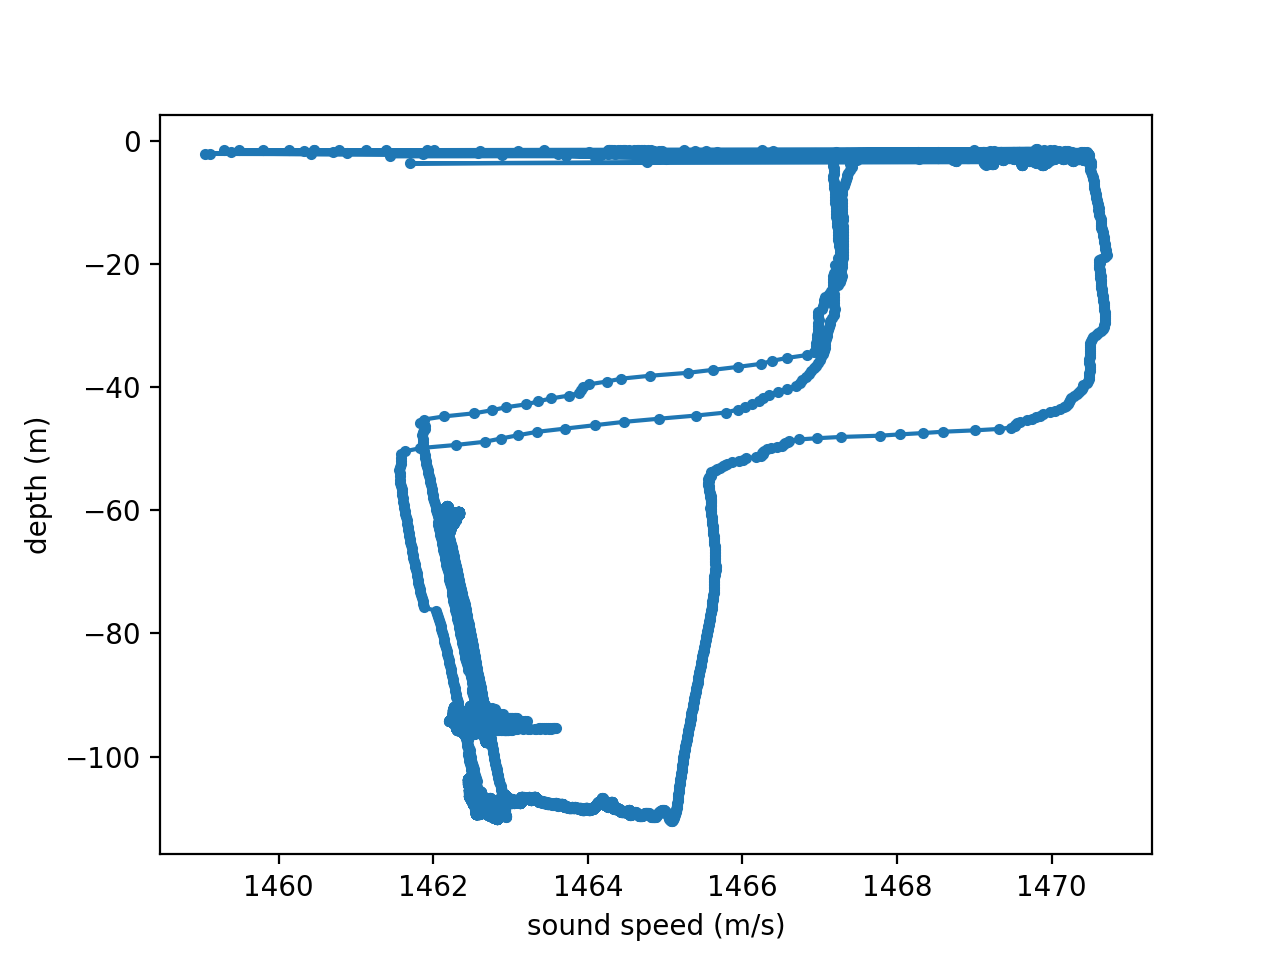

Text(0.5, 0, 'sound speed (m/s)')

In [80]:
fig, ax = plt.subplots(nrows=1, ncols=1)

#plt.plot(ctd_df[aug_10]['ssp'], -ctd_df[aug_10]['Depth'], marker='.')
plt.plot(ctd_df[aug_11]['ssp'], -ctd_df[aug_11]['Depth'], marker='.')

ax.set_ylabel('depth (m)')
ax.set_xlabel('sound speed (m/s)')

# Multibeam data

In [47]:
file_in = 'pointcloud-xyza.xyz' #r"""/mnt/c/Users/andrea.munafo/Downloads/AYE-to-review/AYE_Sample/AYE_Sample/JC0124/M87/multi-beam-echosounder/xyz/M87_xyz_multi-beam-echosounder.xyz""" #CHANGE HERE
raster_out = r"""./RasterOut.tif""" #CHANGE HERE

In [48]:
x,y,z,a = np.loadtxt(file_in, skiprows=1, delimiter=",",unpack = True) #CHANGE HERE
xmin,xmax,ymin,ymax = [min(x),max(x),min(y),max(y)]

#size of 1 m grid
nx = (int(xmax - xmin + 1))#CHANGE HERE
ny = (int(ymax - ymin + 1))#CHANGE HERE

# Generate a regular grid to interpolate the data.
xi = np.linspace(xmin, xmax, nx)
yi = np.linspace(ymin, ymax, ny)
xi, yi = np.meshgrid(xi, yi) 

In [ ]:
# Interpolate the values of z for all points in the rectangular grid
# Method 1 - Interpolate by matplotlib delaunay triangularizatio and nearest neigh. PLEASE NOTE! THIS FAILS QUITE OFTEN (http://matplotlib.org/api/mlab_api.html#matplotlib.mlab.griddata) But there might be a solution - install mpl_toolkits.natgrid (http://matplotlib.org/mpl_toolkits/)
zi = ml.griddata(x,y,z,xi,yi,interp='nn') #interpolation is 'nn' by default (natural neighbour based on delaunay triangulation) but 'linear' is faster (see http://matplotlib.1069221.n5.nabble.com/speeding-up-griddata-td20906.html)
# PLEASE NOTE! Method 1 fails sometimes and then using mpl_toolkits.natgrid may be a solution (http://matplotlib.org/api/mlab_api.html#matplotlib.mlab.griddata) (http://matplotlib.org/mpl_toolkits/)


In [51]:
zi = il.griddata((x, y), z, (xi, yi), method='linear') #(may use 'nearest', 'linear' or 'cubic'  - although constant problems w linear) 

/home/andreamunafo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  


/home/andreamunafo/.local/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


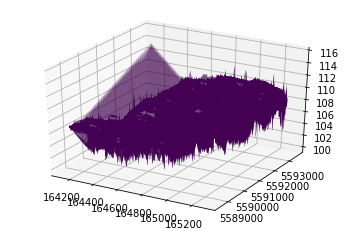

In [52]:
%matplotlib notebook #qt 
fig = plt.figure()
ax = plt.axes(projection='3d')

#ax.contour3D(xi, yi, zi) #, cmap='binary')
ax.plot_surface(xi, yi, zi, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')

---------------  Write to GeoTIFF ------------------------

In [15]:
nrows,ncols = np.shape(zi)
xres = (xmax-xmin)/float(ncols)
yres = (ymax-ymin)/float(nrows)

geotransform = (xmin,xres,0,ymin,0, yres) 
driver = gdal.GetDriverByName('GTiff')

In [16]:
output_raster = driver.Create(raster_out, ncols, nrows, 1, gdal.GDT_Float32, ['TFW=YES', 'COMPRESS=PACKBITS'])  # Open the file, see here for information about compression: https://gis.stackexchange.com/questions/1104/should-gdal-be-set-to-produce-geotiff-files-with-compression-which-algorithm-sh
output_raster.SetGeoTransform(geotransform)  # Specify its coordinates
srs = osr.SpatialReference()                 # Establish its coordinate encoding
srs.ImportFromEPSG(3010)                     # This one specifies SWEREF99 16 30
output_raster.SetProjection( srs.ExportToWkt() )   # Exports the coordinate system to the file
output_raster.GetRasterBand(1).WriteArray(zi)      # Writes my array to the raster

0

In [17]:
img = cv2.imread(raster_out, cv2.IMREAD_GRAYSCALE)

SystemError: <built-in function imread> returned NULL without setting an error

TypeError: Image data of dtype object cannot be converted to float

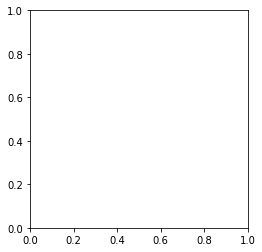

In [14]:
plt.imshow(img, cmap='gray')